# I- Corrélation entre attributs et suppression manuelle de quelques features


In [ ]:
%pip install pandas

In [ ]:
%pip install matplotlib

In [ ]:
%pip install jinja2

In [ ]:
%pip install sklearn

In [ ]:
%pip install seaborn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73632 entries, 0 to 73631
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Num_Acc                   73632 non-null  int64  
 1   num_veh                   73632 non-null  int32  
 2   id_usa                    73632 non-null  int64  
 3   date                      73632 non-null  int64  
 4   ville                     73632 non-null  int32  
 5   id_code_insee             73632 non-null  int32  
 6   latitude                  73632 non-null  float64
 7   longitude                 73632 non-null  float64
 8   descr_cat_veh             73632 non-null  int64  
 9   descr_agglo               73632 non-null  int32  
 10  descr_athmo               73632 non-null  int32  
 11  descr_lum                 73632 non-null  int32  
 12  descr_etat_surf           73632 non-null  int32  
 13  description_intersection  73632 non-null  int32  
 14  an_nai

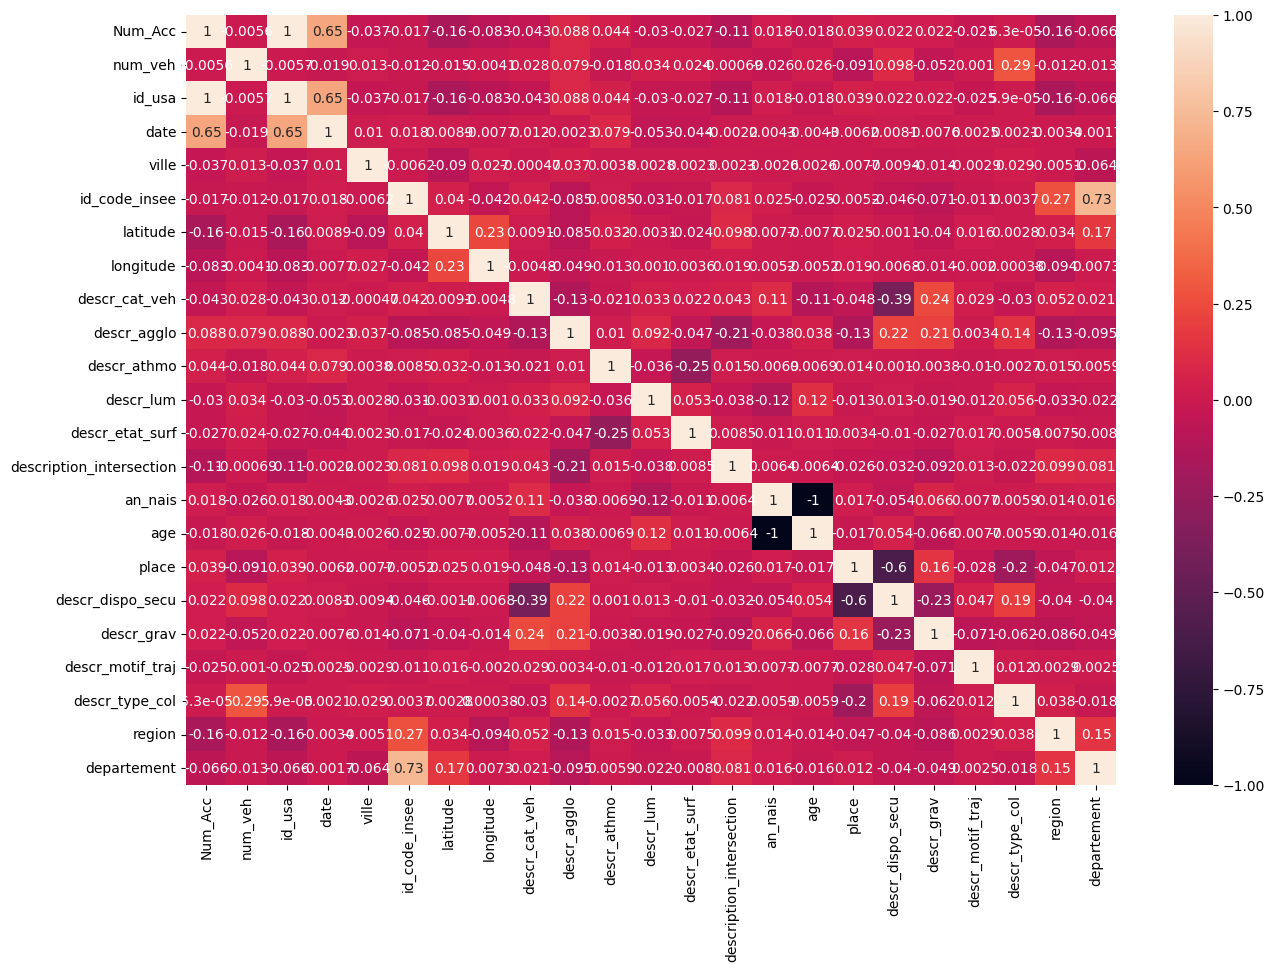

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
accidents = pd.read_csv('../df.csv')
df = pd.DataFrame(accidents)
enc = preprocessing.LabelEncoder()
#convertit en numérique les colonnes
num_veh = df["num_veh"]
df["num_veh"] = enc.fit_transform(num_veh)
date = df["date"]
df["date"] = enc.fit_transform(date)
ville = df["ville"]
df["ville"] = enc.fit_transform(ville)
code_insee = df["id_code_insee"]
df["id_code_insee"] = enc.fit_transform(code_insee)
agglo = df["descr_agglo"]
df["descr_agglo"] = enc.fit_transform(agglo)
athmo = df["descr_athmo"]
df["descr_athmo"] = enc.fit_transform(athmo)
lum = df["descr_lum"]
df["descr_lum"] = enc.fit_transform(lum)
etat_surf = df["descr_etat_surf"]
df["descr_etat_surf"] = enc.fit_transform(etat_surf)
intersection = df["description_intersection"]
df["description_intersection"] = enc.fit_transform(intersection)
secu = df["descr_dispo_secu"]
df["descr_dispo_secu"] = enc.fit_transform(secu)
motif_traj = df["descr_motif_traj"]
df["descr_motif_traj"] = enc.fit_transform(motif_traj)
type_collision = df["descr_type_col"]
df["descr_type_col"] = enc.fit_transform(type_collision)
region = df["region"]
df["region"] = enc.fit_transform(region)
departement = df["departement"]
df["departement"] = enc.fit_transform(departement)








df.info()
df
#matrice de correlation
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True)
plt.xticks(rotation=90)
plt.show()

#supprimer colonne
#del df['nom colonne']


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accidents = pd.read_csv('../df.csv')
df = pd.DataFrame(accidents)
df.info()
df.drop((df[(df['num_veh'])]).index, inplace=True)
accidents.info()
corr_df = accidents.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73632 entries, 0 to 73631
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Num_Acc                   73632 non-null  int64  
 1   num_veh                   73632 non-null  object 
 2   id_usa                    73632 non-null  int64  
 3   date                      73632 non-null  int64  
 4   ville                     73632 non-null  object 
 5   id_code_insee             73632 non-null  object 
 6   latitude                  73632 non-null  float64
 7   longitude                 73632 non-null  float64
 8   descr_cat_veh             73632 non-null  int64  
 9   descr_agglo               73632 non-null  object 
 10  descr_athmo               73632 non-null  object 
 11  descr_lum                 73632 non-null  object 
 12  descr_etat_surf           73632 non-null  object 
 13  description_intersection  73632 non-null  object 
 14  an_nai

KeyError: "None of [Index(['B02', 'B02', 'B02', 'B02', 'A01', 'B02', 'B02', 'A01', 'B02', 'A01',\n       ...\n       'A01', 'A01', 'A01', 'A01', 'A01', 'A01', 'A01', 'A01', 'A01', 'A01'],\n      dtype='object', length=73632)] are in the [columns]"